In [78]:
from gtda.plotting import plot_point_cloud
from generate_data import make_point_clouds

from gtda.mapper.cluster import FirstSimpleGap

from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from scipy.stats import rankdata
# Data wrangling
import numpy as np
#import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# TDA magic
from gtda.mapper import (
#    CubicalCover,
    make_mapper_pipeline,
#    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)

#import filtering functions
from gtda.mapper.filter import Eccentricity, Entropy, Projection

#import clustering functions
from gtda.mapper.cluster import ParallelClustering, Agglomerative, FirstHistogramGap

#import cover functions
from gtda.mapper.cover import OneDimensionalCover, CubicalCover

import open3d as o3d
from umap import UMAP

import gzip
import shutil
import os
import matplotlib.pyplot as plt

from copy import deepcopy
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patches as patches

import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from tqdm import tqdm

from sklearn.base import clone
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from numpy.random import default_rng
rng = default_rng(42)  # Create a random number generator

import sklearn

In [2]:
def extract_gz_files(folder):
    r = []
    for file in os.listdir(folder):
        if file.split('.')[-1]=='gz':
            full_path = os.path.join(folder, file)
            file_extension = file.split('.')[-2]
            new_file_path = os.path.join(folder, ''.join(file.split('.')[:-2])+"."+str(file_extension))
            r.append(new_file_path)
            with gzip.open(full_path, 'rb') as f_in:
                with open(new_file_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
    return r

def get_ply_files(folder):
    files = list(filter(lambda file: file.split('.')[-1]=='ply', os.listdir(folder)))
    files = list(map(lambda file: os.path.join(folder, file),files))
    return files

In [33]:
#files = extract_gz_files('/Users/zanjonke/Downloads/tablesPly')
#ply_files  = extract_gz_files('data/tablesPly')
#ply_files += extract_gz_files('data/chairsPly')
#ply_files += extract_gz_files('data/cupsPly')
#ply_files += extract_gz_files('data/humansPly')

ply_files  = get_ply_files('data/tablesPly')
ply_files += get_ply_files('data/chairsPly')
ply_files += get_ply_files('data/cupsPly')
ply_files += get_ply_files('data/humansPly')


In [248]:
# print(len(ply_files)) 99
#print(ply_files)
pcd = o3d.io.read_point_cloud(ply_files[81]) # Read the point cloud
pcd = np.asarray(pcd.points) 


In [209]:
#point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=10, n_points=100, noise=0.2)
point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=10, n_points=50, noise=0.2)
pcd = point_clouds_basic[10]


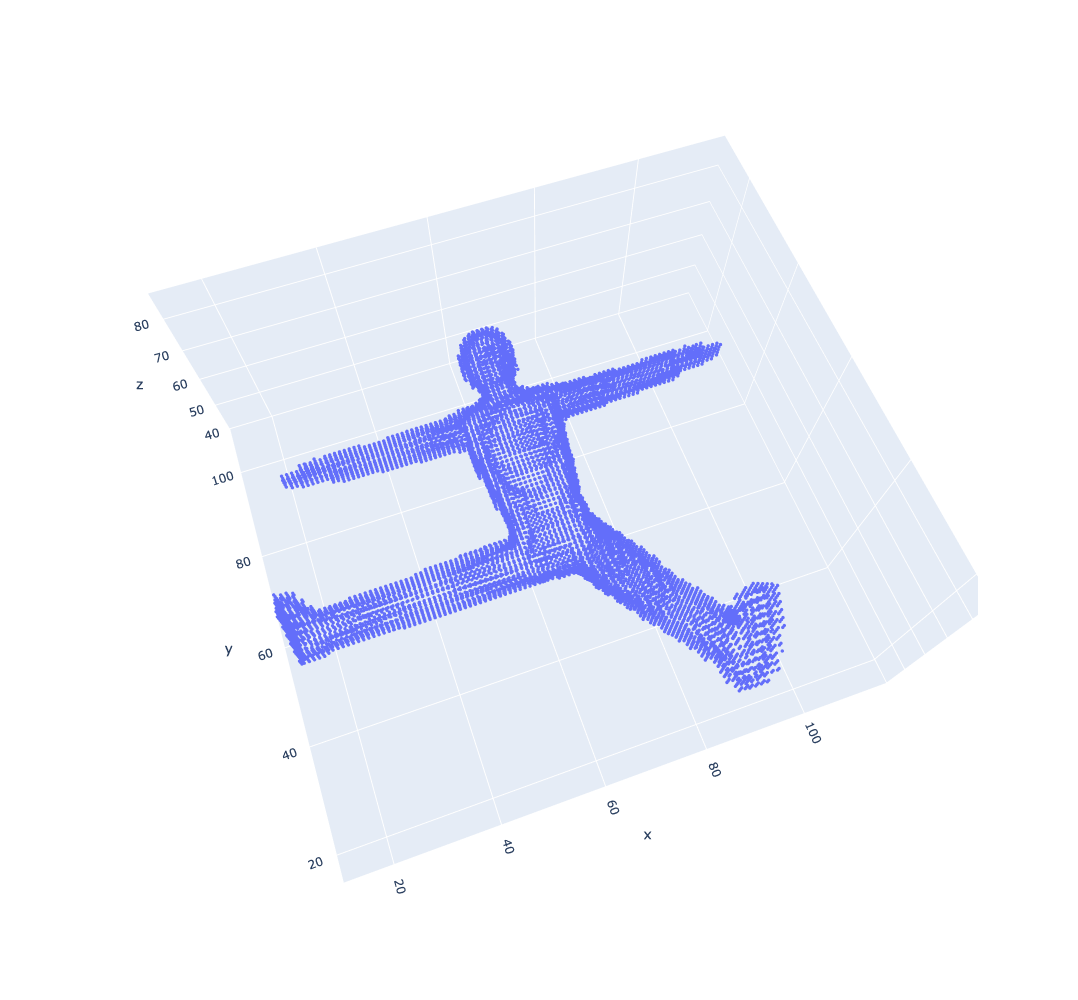

In [247]:
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        mode='markers',
        x=pcd[:,0],
        y=pcd[:,1],
        z=pcd[:,2],
        marker=dict(
            size=2
        )
        
    )
)
m = 100
fig.update_layout(height=1000, width=1000,margin=dict(r=m, l=m,b=m, t=m))
fig.show()

{'clusterer': DBSCAN(eps=10, metric='chebyshev'),
 'cover': CubicalCover(n_intervals=5),
 'filter_func': PCA(n_components=2)}


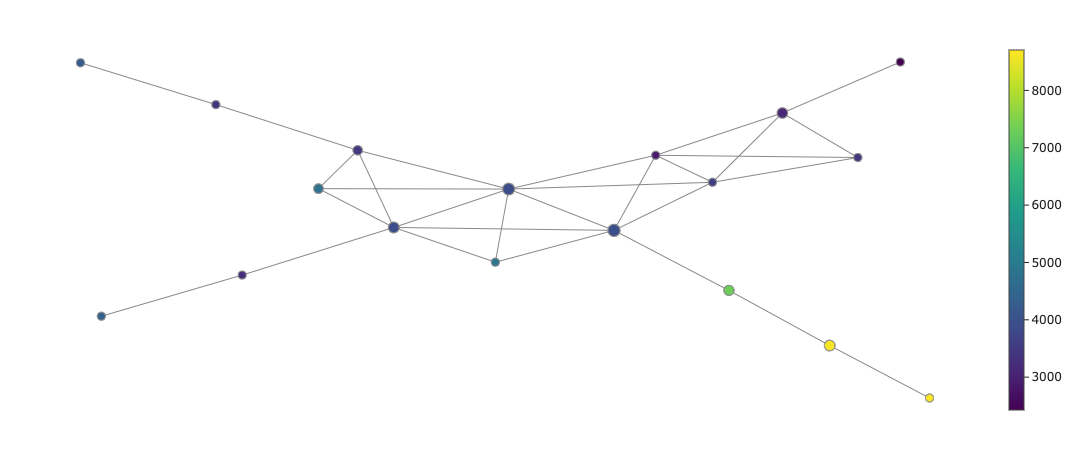

In [230]:
mappers = {
    'torus':{
        'filter_func':Projection(columns=[0,1]),
        'cover':CubicalCover(n_intervals=2, overlap_frac=0.2),
        'clusterer':DBSCAN(eps=10)
    },
    'sphere':{
        'filter_func':Projection(columns=[0,1]),
        'cover':CubicalCover(n_intervals=2, overlap_frac=0.2),
        'clusterer':DBSCAN(eps=10)
    },
    'human':{
        #'filter_func':Projection(columns=[0,1]),
        'filter_func':PCA(n_components=2),
        #'filter_func':UMAP(n_neighbors=5),
        'cover':CubicalCover(n_intervals=5, overlap_frac=0.1),
        'clusterer':DBSCAN(eps=10,metric='chebyshev')
    },
    'table':{
        'filter_func':Projection(columns=[0,1,2]),
        'cover':CubicalCover(n_intervals=4, overlap_frac=0.4),
        'clusterer':DBSCAN(eps=10)
    }, 
    'chair':{
        'filter_func':Projection(columns=[0,1,2]),
        'cover':CubicalCover(n_intervals=3, overlap_frac=0.2),
        'clusterer':DBSCAN(eps=10)

    }
}

body = 'human'
#body = 'torus'
#body = 'chair'
#body = 'table'
pprint(mappers[body])
# Define filter function – can be any scikit-learn transformer
filter_func = mappers[body]['filter_func']
#filter_func = Projection(columns=[0,1])
#filter_func = PCA()
#filter_func = Eccentricity()
#filter_func = Entropy()
#filter_func = Projection()
#filter_func = UMAP(n_neighbors=5)

# Define cover
cover = mappers[body]['cover']
#cover = CubicalCover(n_intervals=2, overlap_frac=0.2)

# Choose clustering algorithm – default is DBSCAN
clusterer = mappers[body]['clusterer']
#clusterer = DBSCAN(eps=10)

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
#plot_interactive_mapper_graph(pipe, pcd, color_data=pcd)
fig = plot_static_mapper_graph(pipe, pcd)
fig.show(config={'scrollZoom': True})

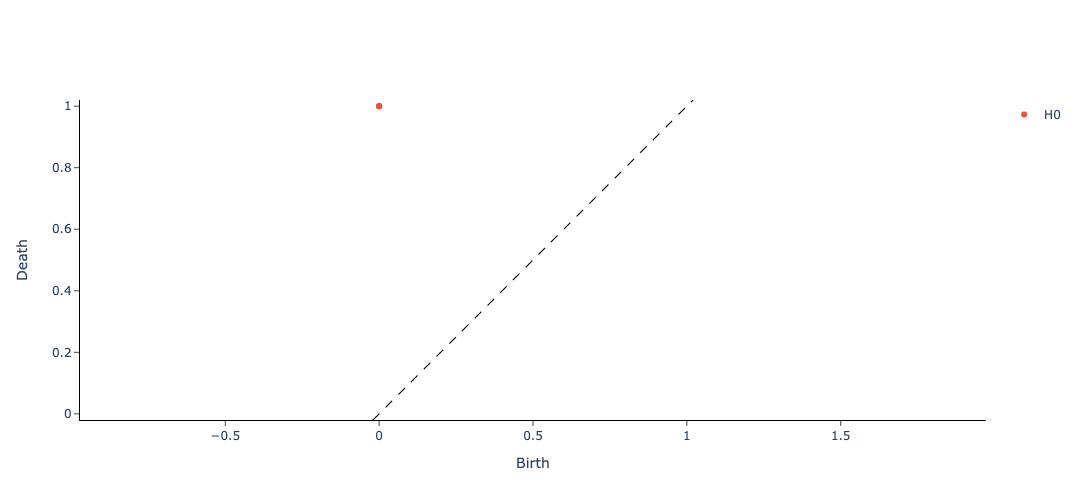

In [108]:
graph = pipe.fit_transform(pcd)
adj = np.array([graph.get_adjacency().data])

rows = []
columns = []
weights = []
for idxi, row in enumerate(adj[0]):
    for idxj, col in enumerate(row):
        if idxj < idxi:
            continue
        if col != 0:
            rows.append(idxi)
            columns.append(idxj)
            weights.append(1.0)


adj = coo_matrix((weights, (rows, columns)))
homology_dimensions = [0, 1, 2]

r = VietorisRipsPersistence(metric="precomputed", homology_dimensions=homology_dimensions).fit_transform([adj]);

plot_diagram(r[0])

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
plt.scatter(X[:,0], X[:,1])

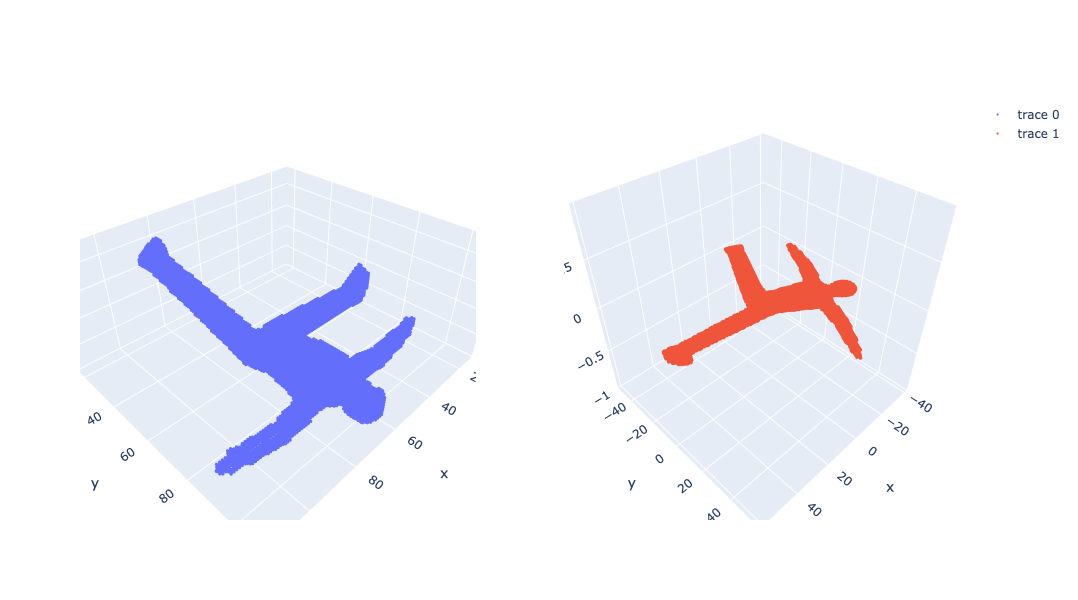

In [231]:

#filter_func = Projection(columns=[0,1])
#filter_func = PCA(n_components=2)
#filter_func = UMAP(n_neighbors=5)

X = deepcopy(pcd[:,0:3])
X_ = filter_func.fit_transform(X)


fig = make_subplots(rows=1, cols=2,specs=[[{'type': 'surface'}, {'type': 'surface'}]])

fig.add_trace(
    go.Scatter3d(x=X[:,0], y=X[:,1],z=X[:,2],mode = 'markers',marker = dict(size = 2)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter3d(x=X_[:,0], y=X_[:,1],z=[0]*X_.shape[0],mode = 'markers',marker = dict(size = 2)),
    row=1, col=2
)

#fig.add_trace(
#    go.Scatter3d(x=X_[:,0], y=X_[:,1],z=X_[:,2],mode = 'markers',marker = dict(size = 2)),
#    row=1, col=2
#)

fig.update_layout(height=600, width=1000)
fig.show()

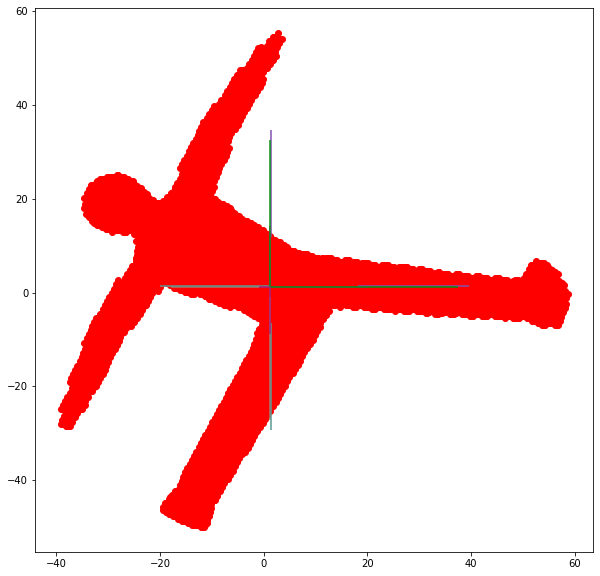

In [232]:
#cover = CubicalCover(n_intervals=2, overlap_frac=0.2)
#cover = CubicalCover(n_intervals=2, overlap_frac=0.3)
#cover = CubicalCover(n_intervals=2, overlap_frac=0.2)

X__ = cover.fit_transform(X_)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_[:,0],X_[:,1],color='r')

#offset = 4
offset = 1.5
lim = 1.25
#lim = 3.5
step = 0.25
lim_neg = -1
#lim_neg = -10
random_color = lambda: random.randint(0,255)
color_discrete_map={str(i):'#%02X%02X%02X' % (random_color(),random_color(),random_color()) for i in range(0,100)}
#pprint(color_discrete_map)

#print(cmap)

for i, (left_limit, right_limit) in enumerate(zip(cover._coverers[0].left_limits_, cover._coverers[0].right_limits_)):
    if left_limit == -np.inf: left_limit = lim_neg 
    if right_limit == np.inf: right_limit = lim
    #X = np.linspace(left_limit, right_limit, 100)
    #Y = np.linspace(left_limit, right_limit, 100)
    color = color_discrete_map[str(i)]
    y = offset-step if i %2 == 0 else offset
    ax.hlines(y=y, xmin=left_limit, xmax=right_limit, colors=color)

for i, (left_limit, right_limit) in enumerate(zip(cover._coverers[1].left_limits_, cover._coverers[1].right_limits_)):
    if left_limit == -np.inf: left_limit = lim_neg
    if right_limit == np.inf: right_limit = lim
    color = color_discrete_map[str(i)]
    x = offset-step if i %2 == 0 else offset
    ax.vlines(x=x, ymin=left_limit, ymax=right_limit, colors=color)


In [240]:
groups = [X[X__[:,i]].tolist() for i in range(0, X__.shape[1])]
s = [{tuple(p) for p in group} for group in groups]

def check_if_point_is_intersecting(intersections, point):
    point = point.tolist()
    for i, l in enumerate(intersections):
        for j, intersecting_points in enumerate(l):
            if i == j:
                continue
            intersecting_points = intersecting_points.tolist()
            if point in intersecting_points:
                return True
    return False

intersections = []
for i,si in enumerate(s):
    intersecting_points = []
    for j,sj in enumerate(s):
        intersecting_points.append(np.array([list(p) for p in si & sj]))
    intersections.append(intersecting_points)
    
labels = []
for point in tqdm(X):
    point = point.tolist()
    #if check_if_point_is_intersecting(intersections,point):

    #    labels.append(len(groups))
    #    continue
     
    num_of_groups_found = 0
    group_id = -1
    for idx, group in enumerate(groups):
        #group = group.tolist()
        if point in group:
            num_of_groups_found += 1
            group_id = idx
            
    if num_of_groups_found > 1:
        labels.append(len(groups))
    else:
        if group_id == -1:
            raise Exception('No group found')
        labels.append(group_id)
        
labels = [str(l) for l in labels]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9197/9197 [00:02<00:00, 3203.39it/s]


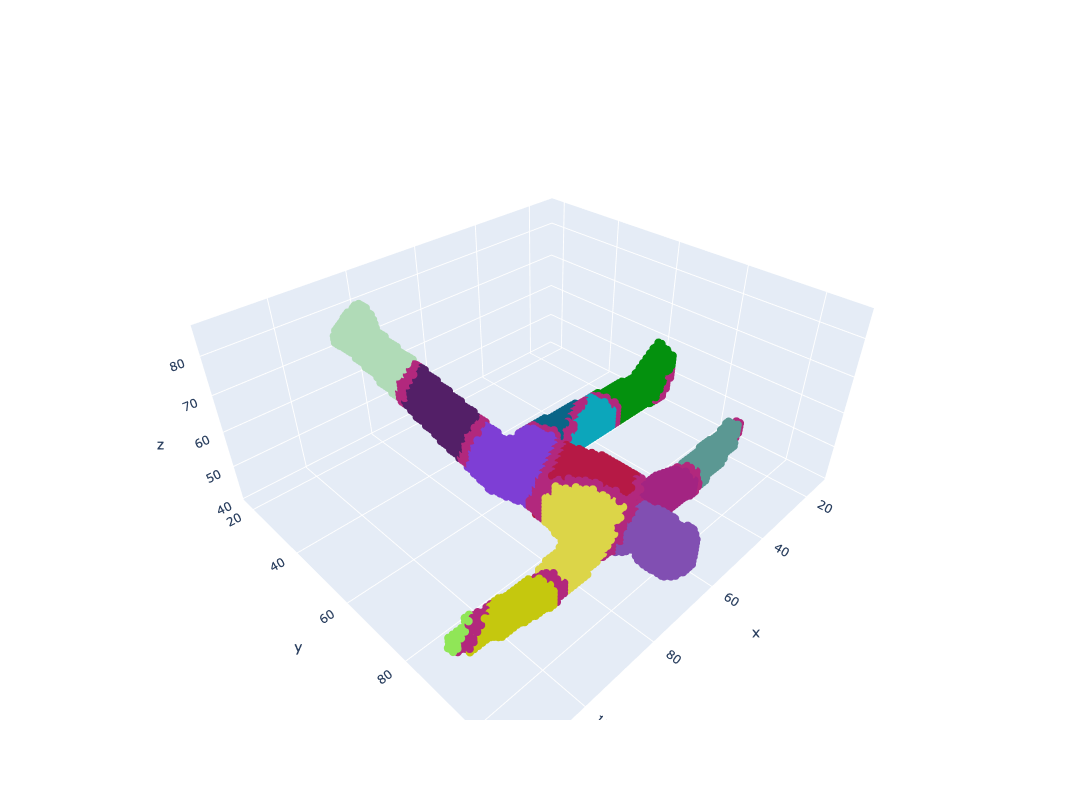

In [241]:
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        mode='markers',
        x=X[:,0],
        y=X[:,1],
        z=X[:,2],
        marker=dict(
            size=5,
            color=[color_discrete_map[l] for l in labels],
            
        )
        
    )
)
fig.update_layout(height=800, width=800)
fig.show()

In [238]:
groups = [np.array(group) for group in groups]
#clusterer = DBSCAN(eps=10)
cluster_result_labels = [clusterer.fit(group).labels_ for group in groups]

if len(groups)%2==0:
    num_rows = int(len(groups)/2)
    num_cols = 2
else:
    num_rows = int((len(groups)//2)+1)
    num_cols = 2

specs = [[{'type': 'surface'}, {'type': 'surface'}] for _ in range(0,num_rows)]
fig = make_subplots(rows=num_rows, cols=num_cols,specs=specs)

for i in range(0,len(groups)):
    for label in np.unique(cluster_result_labels[i]):
        cluster = groups[i][cluster_result_labels[i]==label]
        centroid = (np.mean(cluster[:,0]), np.mean(cluster[:,1]))
        c = np.random.rand(3,)
        fig.add_trace(
            go.Scatter3d(x=cluster[:,0], y=cluster[:,1],z=cluster[:,2], mode = 'markers',marker = dict(size = 2)), row=(i//2)+1, col=(i%2)+1
        )

fig.update_layout(height=600, width=600)
fig.show()
"""

"\nif len(groups)%2==0:\n    num_rows = int(len(groups)/2)\n    num_cols = 2\nelse:\n    num_rows = int((len(groups)//2)+1)\n    num_cols = 2\n\nspecs = [[{'type': 'surface'}, {'type': 'surface'}] for _ in range(0,num_rows)]\nfig = make_subplots(rows=num_rows, cols=num_cols,specs=specs)\n\nfor i in range(0,len(groups)):\n    for label in np.unique(cluster_result_labels[i]):\n        cluster = groups[i][cluster_result_labels[i]==label]\n        centroid = (np.mean(cluster[:,0]), np.mean(cluster[:,1]))\n        c = np.random.rand(3,)\n        fig.add_trace(\n            go.Scatter3d(x=cluster[:,0], y=cluster[:,1],z=cluster[:,2], mode = 'markers',marker = dict(size = 2)), row=(i//2)+1, col=(i%2)+1\n        )\n\nfig.update_layout(height=600, width=600)\nfig.show()\n"

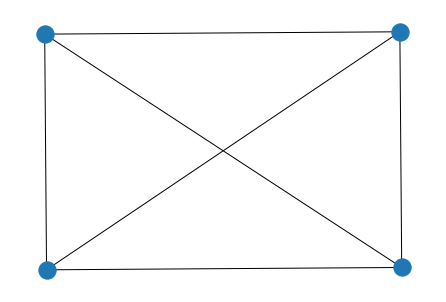

In [239]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G)